In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay , classification_report , accuracy_score ,precision_recall_curve , roc_curve ,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import PrecisionRecallDisplay

warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
df = pd.read_csv('./data.csv')
vars = df.iloc[:, 2:-1]
# vectorize the target data. M = 1 and B = 0 diagnosis
target = df.iloc[:, 1].apply(lambda x: 1 if x == 'M' else 0)

In [4]:
X =  pd.DataFrame(preprocessing.StandardScaler().fit_transform(vars))
y = target
X.columns = vars.columns
# Use ANOVA F-value as the scoring function for feature selection 
# f_classif is specify we using ANOVA
# k is the number of features we want to get
selector = SelectKBest(score_func=f_classif, k=15)
# Fit the selector to the data
selector.fit(vars, target)
# Get the scores and p-values of each feature
scores = selector.scores_
p_values = selector.pvalues_

results = pd.DataFrame({'Feature': vars.columns, 'Score': scores, 'p-value': p_values})
results.sort_values(by='Score', ascending=False, inplace=True)
# Select the top K features based on the scores
top_features = vars.columns[selector.get_support()]
# Display the top features
print(top_features)
print(results)

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se',
       'area_se', 'radius_worst', 'perimeter_worst', 'area_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst'],
      dtype='object')
                    Feature       Score        p-value
27     concave points_worst  964.385393  1.969100e-124
22          perimeter_worst  897.944219  5.771397e-119
7       concave points_mean  861.676020  7.101150e-116
20             radius_worst  860.781707  8.482292e-116
2            perimeter_mean  697.235272  8.436251e-101
23               area_worst  661.600206   2.828848e-97
0               radius_mean  646.981021   8.465941e-96
3                 area_mean  573.060747   4.734564e-88
6            concavity_mean  533.793126   9.966556e-84
26          concavity_worst  436.691939   2.464664e-72
5          compactness_mean  313.233079   3.938263e-56
25        compactness_worst  

In [5]:
X = X.loc[:,top_features]
X

,radius_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,radius_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst
0,1.097064,1.269934,0.984375,3.283515,2.652874,2.532475,2.489734,2.833031,2.487578,1.886690,2.303601,2.001237,2.616665,2.109526,2.296076
1,1.829821,1.685955,1.908708,-0.487072,-0.023846,0.548144,0.499255,0.263327,0.742402,1.805927,1.535126,1.890489,-0.430444,-0.146749,1.087084
2,1.579888,1.566503,1.558884,1.052926,1.363478,2.037231,1.228676,0.850928,1.181336,1.511870,1.347475,1.456285,1.082932,0.854974,1.955000
3,-0.768909,-0.592687,-0.764464,3.402909,1.915897,1.451707,0.326373,0.286593,-0.288378,-0.281464,-0.249939,-0.550021,3.893397,1.989588,2.175786
4,1.750297,1.776573,1.826229,0.539340,1.371011,1.428493,1.270543,1.273189,1.190357,1.298575,1.338539,1.220724,-0.313395,0.613179,0.729259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,2.060786,2.343856,0.219060,1.947285,2.320965,2.782080,2.379583,2.604187,1.901185,1.752563,2.015301,-0.273318,0.664512,1.629151
565,1.704854,1.615931,1.723842,-0.017833,0.693043,1.263669,1.300499,1.156857,1.291565,1.536720,1.421940,1.494959,-0.394820,0.236573,0.733827
566,0.702284,0.672676,0.577953,-0.038680,0.046588,0.105777,0.184892,0.276693,0.180698,0.561361,0.579001,0.427906,0.350735,0.326767,0.414069
567,1.838341,1.982524,1.735218,3.272144,3.296944,2.658866,1.157935,1.438530,1.009503,1.961239,2.303601,1.653171,3.904848,3.197605,2.289985


In [6]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

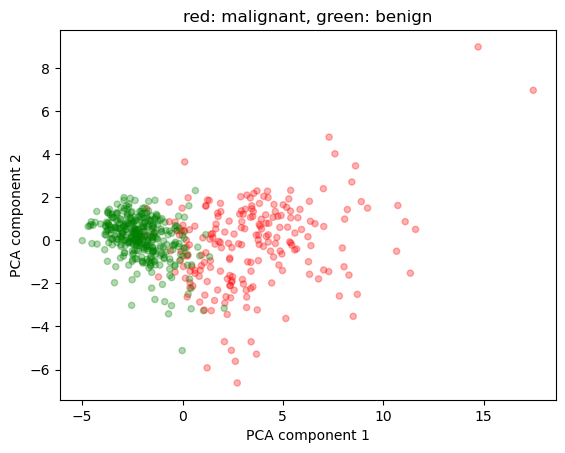

In [7]:
draw = X.loc[:, top_features]
#draw = pd.merge(X, y, left_index=True, right_index=True)
pca = PCA(n_components=2)
pca.fit(draw)
T = pca.transform(draw)
T = pd.DataFrame(T)
# plot the data
T.columns = ['PCA component 1', 'PCA component 2']
T.plot.scatter(x='PCA component 1', y='PCA component 2',
	marker='o',
    alpha=0.3,
    color=['red' if i==1 else 'green' for i in y],
    title="red: malignant, green: benign")
plt.show()

In [8]:
# Stratify: split the training and testing by 80/20
train_features, test_features, train_targets, test_targets = train_test_split(X, y, train_size=0.8,test_size=0.2,stratify = y)

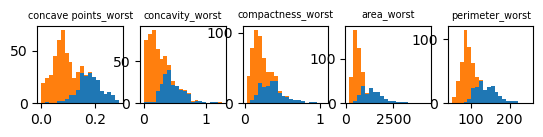

In [9]:
xaxis = [feature for feature in top_features[:-6:-1]]
X_hist1 = [df[[x, 'diagnosis']] for x in xaxis]
X_hist1_1 = [0] * 5
X_hist1_2 = [0] * 5
for i in range(5):
    X_hist1_1[i] = X_hist1[i][X_hist1[i]['diagnosis'] == 'M'][[xaxis[i]]].stack()
    X_hist1_2[i] = X_hist1[i][X_hist1[i]['diagnosis'] == 'B'][[xaxis[i]]].stack()

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
axis = [ax0, ax1, ax2, ax3, ax4 ]
for i in range(5):
    axis[i].hist([X_hist1_1[i], X_hist1_2[i]], bins=20, stacked=True)
    axis[i].set_title(xaxis[i], fontsize=7)
fig.set_figheight(1)

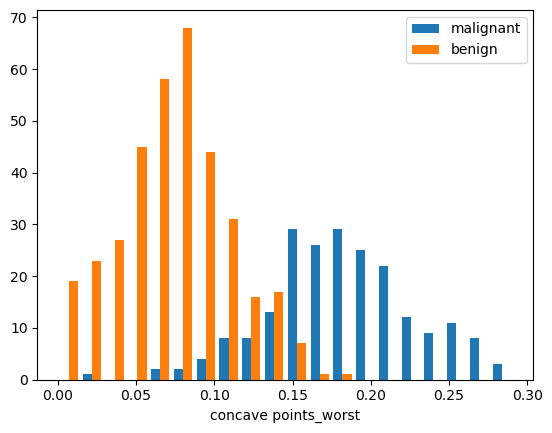

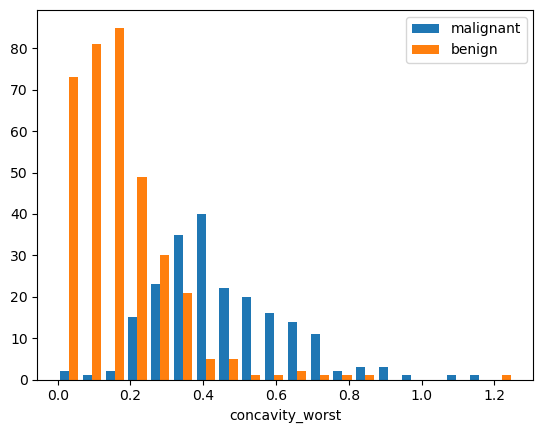

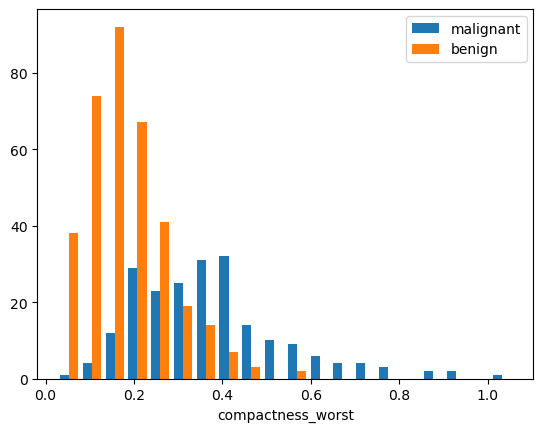

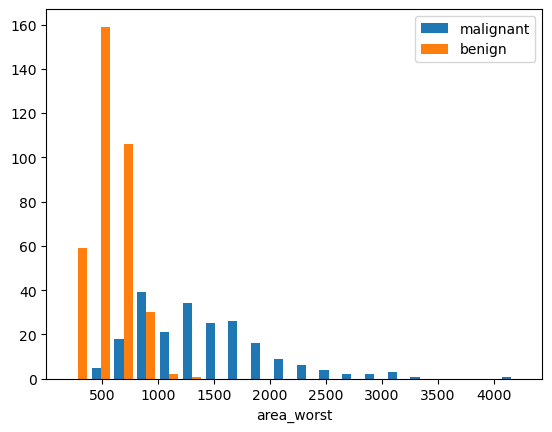

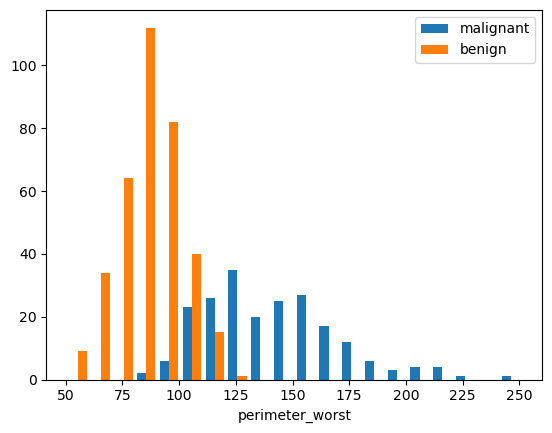

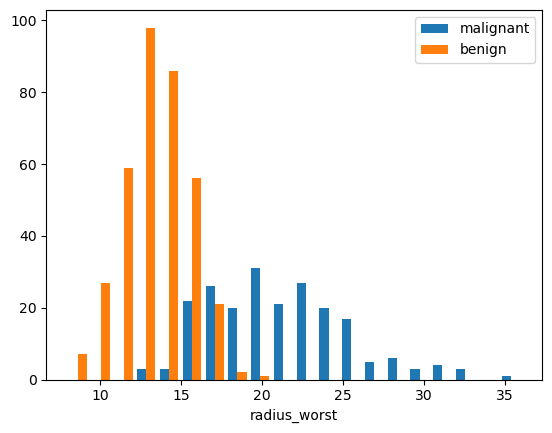

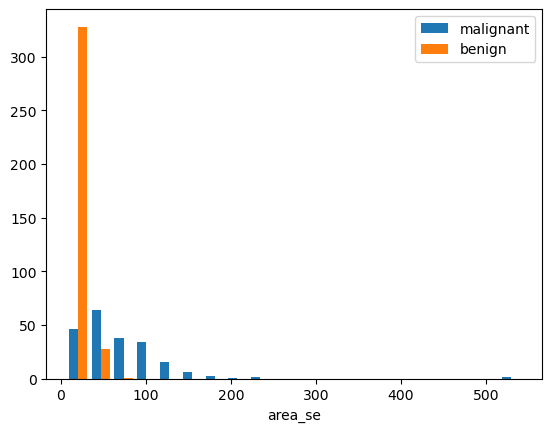

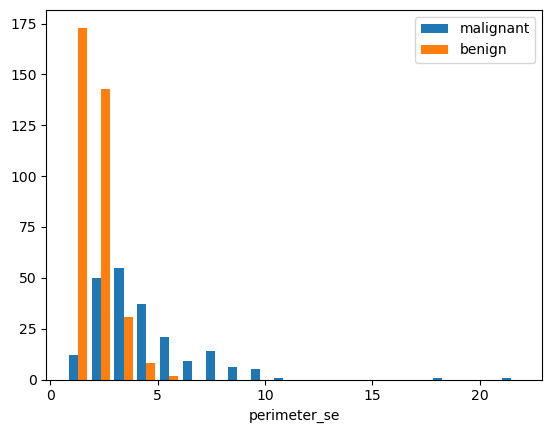

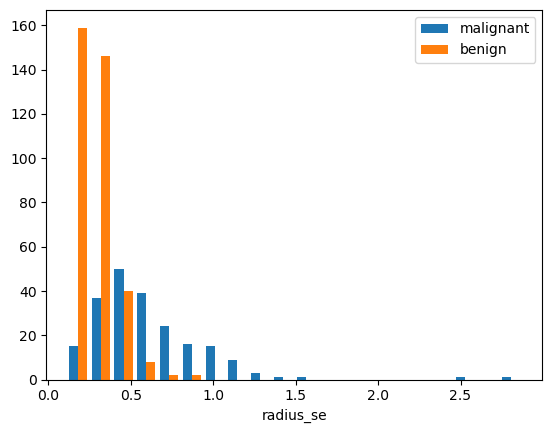

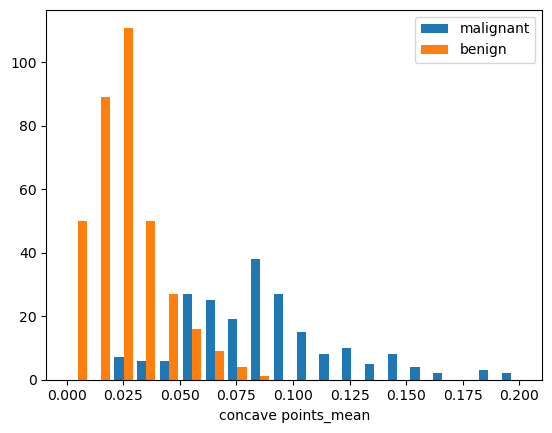

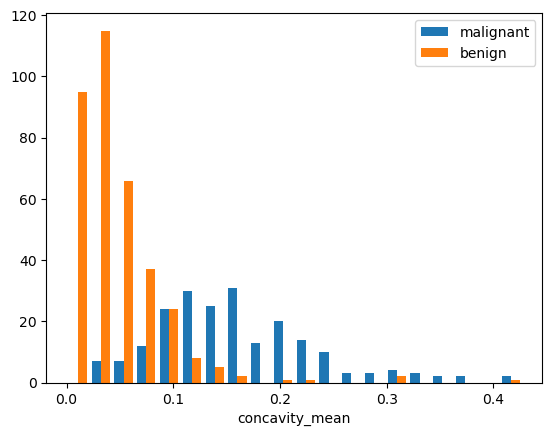

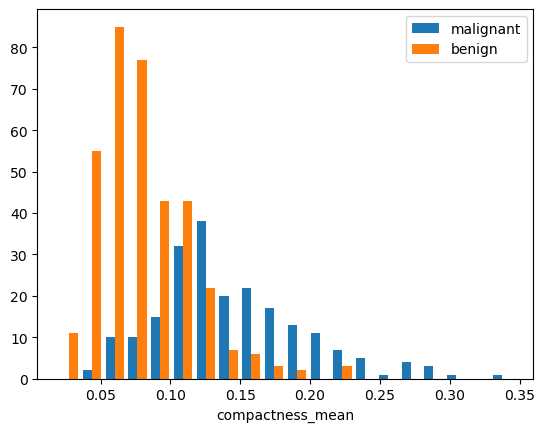

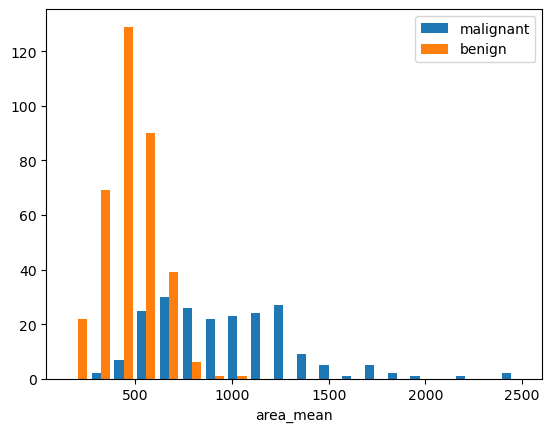

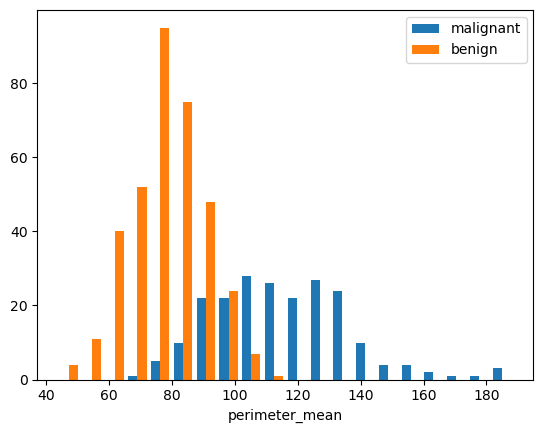

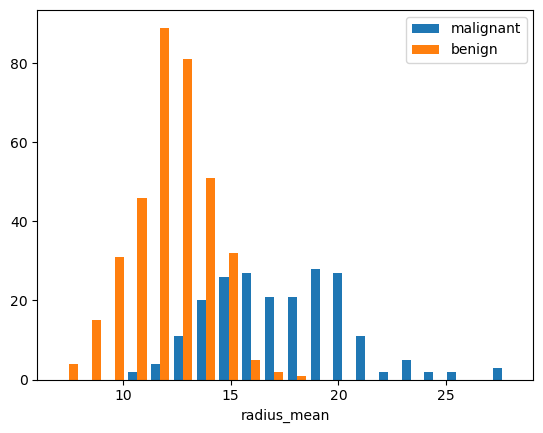

In [11]:
for x in top_features[::-1]:
    X_hist1 = df[[x, 'diagnosis']]
    X_hist1_1 = X_hist1[X_hist1['diagnosis'] == 'M'][[x]].stack()
    X_hist1_2 = X_hist1[X_hist1['diagnosis'] == 'B'][[x]].stack()
    plt.hist([X_hist1_1, X_hist1_2], bins=20)
    plt.xlabel(x)
    plt.legend(['malignant', 'benign'])
    plt.show()


In [152]:
hyperparameters = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
     'max_iter' : [1000, 10000, 25000, 50000]
     }
]
log_model = LogisticRegression(max_iter=10000)
clf = GridSearchCV(log_model, param_grid = hyperparameters, cv = 3, n_jobs=-1)
clf.fit(train_features, train_targets)

In [153]:
display(clf.best_params_)
display(clf.best_estimator_)
display(clf.best_index_)
display(clf.best_score_)

In [154]:
model_1 = LogisticRegression(max_iter=clf.best_params_['max_iter'],C=clf.best_params_['C'],penalty=clf.best_params_['penalty'],solver=clf.best_params_['solver'])
model_1.fit(train_features, train_targets)

In [155]:
prediction = model_1.predict(test_features)

In [156]:
accuracy_score(test_targets, prediction)

In [157]:
CM = confusion_matrix(test_targets, prediction)
tp, fp, fn, tn = np.ravel(CM)
p = tp / (tp + fp)
r = tp / (tp + fn)
f1 = (2 * p * r) / (p + r)

In [158]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=CM)
cm_display.plot(cmap='Blues')

In [159]:
display = PrecisionRecallDisplay.from_estimator(
    model_1, test_features, test_targets, name="LinearSVC"
)
_ = display.ax_.set_title("Precision-Recall curve")

In [160]:
hyperparameters = {
    'hidden_layer_sizes': [(25,), (50,), (100,), (150,), (200,)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300]
}
nn_model = MLPClassifier()
clf2 = GridSearchCV(nn_model, param_grid=hyperparameters, cv=5)
clf2.fit(train_features, train_targets)

In [161]:
clf2.best_params_

In [162]:
model_1 = MLPClassifier(activation=clf2.best_params_['activation'],
                        alpha=clf2.best_params_['alpha'],
                        hidden_layer_sizes=clf2.best_params_['hidden_layer_sizes'],
                        learning_rate=clf2.best_params_['learning_rate'],
                        max_iter=clf2.best_params_['max_iter'],
                        solver=clf2.best_params_['solver'])
model_1.fit(train_features, train_targets)

In [163]:
prediction1 = model_1.predict(test_features)
accuracy_score(test_targets, prediction1)

In [164]:
CM = confusion_matrix(test_targets, prediction1)
tp, fp, fn, tn = np.ravel(CM)
p = tp / (tp + fp)
r = tp / (tp + fn)
f1 = (2 * p * r) / (p + r)
display([tp, fp, fn, tn, p, r, f1])

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=CM)
cm_display.plot(cmap='Blues')

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    model_1, test_features, test_targets, name="LinearSVC"
)
_ = display.ax_.set_title("Precision-Recall curve")